In [4]:
import pandas as pd
import numpy as np
from environment import Environment
from pandas.tseries.offsets import MonthEnd
import instrument
from portfolio import Portfolio
from risk_parity import RiskParity
from copy import copy, deepcopy

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
from historical import HistoricalData
from pandas._libs.tslibs.timestamps import Timestamp, Timedelta

path = "data/"
env_df = pd.read_csv(path + "Consolidated.csv", header = [0,1], index_col=[0])
targets_df = pd.read_csv(path + "Targets.csv", index_col=[0])
features_df = pd.read_csv(path + "Features.csv", header = [0,1], index_col=[0])
exps = pd.read_csv(path+ 'ETF_info.csv', index_col=0).loc[env_df[['EQ', 'EM', 'RE', 'FI']].columns.droplevel(), 'Expense Ratio'].astype(float)
data = HistoricalData(env_df, features_df, targets_df)

date = Timestamp('2014-03-01') + MonthEnd(0)
date_end = date + MonthEnd(62)
env_now = Environment(*data.get_env_args(date))
rp = RiskParity(data)


### Initializing stuff

In [6]:
usd = 200000/env_now.fx['CAD']
w_dict = rp.get_weights_ac(date, asset_classes=np.array(['FI', 'RE', 'EM']))
pos_dict = Portfolio.weights_to_pos(w_dict, env_now, usd)
pos_dict = Portfolio.etf_dict_from_names(pos_dict)
icash = instrument.Cash('USD')
pos_dict[icash] = 0

In [7]:
my_pf = Portfolio(pos_dict)
etf_w = 0.98
etf_total_val= my_pf.calc_value(env_now)*etf_w
opt_total_val = my_pf.calc_value(env_now)*(1-etf_w)

my_pf.rebalance(env_now, Portfolio.weights_to_pos(w_dict, env_now, etf_total_val), exps, time_past=0)


C = 1 + 0.02
K1 = C - 0.03
K2 = C
K3 = C + 0.03
ttm=2

specs = [{'name':'SPY Call 1', 'ccy':'USD', 'is_call':1, 'ul':'SPY US Equity'},
         {'name':'SPY Call 2', 'ccy':'USD', 'is_call':1, 'ul':'SPY US Equity'},
         {'name':'SPY Call 3', 'ccy':'USD', 'is_call':1, 'ul':'SPY US Equity'}
         ]

cost = Portfolio.get_opt_strategy_price(env_now, specs, [1, -2, 1], [K1,K2,K3], ttm=ttm)
nopt = opt_total_val/cost
ofee, ospread = my_pf.buy_options(env_now, specs, [nopt, -nopt*2, nopt], [K1,K2,K3], ttm=ttm)

last_pf_val = my_pf.calc_value(env_now)
last_etf_val = my_pf.get_eq_value(env_now)

last_eq_val = my_pf.get_names_value(env_now, env_df['EQ'].columns)
last_fi_val = my_pf.get_names_value(env_now, env_df['FI'].columns)
last_re_val = my_pf.get_names_value(env_now, env_df['RE'].columns)
last_em_val = my_pf.get_names_value(env_now, env_df['EM'].columns)

last_opt_val = my_pf.get_options_value(env_now)



### Set up performance df

In [8]:
perf_df = pd.DataFrame(index = pd.date_range(start=date, end=date_end, freq='M'))

# us and cad portf values after rebalancing each month
perf_df['USD Value'] = 0
perf_df['CAD Value'] = 0

perf_df['PNL'] = np.nan  # PNL before rebalancing
perf_df['Post-trading PNL'] = np.nan  # PNL after trading fees and expenses
perf_df['Post-fee PNL'] = np.nan  # PNL after trading fees and expenses and advisor fees

# PNL attributions for ETFs
perf_df['ETF PNL'] = np.nan
perf_df['EQ PNL'] = np.nan
perf_df['FI PNL'] = np.nan
perf_df['EM PNL'] = np.nan
perf_df['RE PNL'] = np.nan

# PNL attributions for Options
perf_df['Option PNL'] = np.nan
perf_df['Delta PNL'] = np.nan
perf_df['Vega PNL'] = np.nan
perf_df['Theta PNL'] = np.nan
perf_df['Rho PNL'] = np.nan
perf_df['Unexplained PNL'] = np.nan

# below is the PNL values divided by the portfolio value at the end of last rebalancing (returns)
perf_df['Return'] = np.nan
perf_df['Post-trading Return'] = np.nan
perf_df['Post-fee Return'] = np.nan

perf_df['ETF Return'] = np.nan
perf_df['EQ Return'] = np.nan
perf_df['FI Return'] = np.nan
perf_df['EM Return'] = np.nan
perf_df['RE Return'] = np.nan

perf_df['Option Return'] = np.nan
perf_df['Delta Return'] = np.nan
perf_df['Vega Return'] = np.nan
perf_df['Theta Return'] = np.nan
perf_df['Rho Return'] = np.nan
perf_df['Unexplained Return'] = np.nan


perf_df['Injection'] = 0  # injectios of 20k CAD
perf_df['FX'] = env_now.fx['CAD']  # fx for converting CAD to USD

# ETF trading fees and management expenses in $
perf_df['ETF Fees'] = 0
perf_df['ETF Expenses'] = 0

# option trading fees and bid-ask spread losses in $
perf_df['Option Fees'] = ofee
perf_df['Option Spread'] = ospread

# total trading fees, expenses and spread losses in $
perf_df['Total Trading Fees'] = 0

# total advisor fees in $
perf_df['Advisor Fees'] = 0
# total fees in $
perf_df['Total Fees'] = 0

# total trading fees, expenses and spread losses as a fraction of pre-rebalancing portfolio value
perf_df['Percentage Trading Fees'] = 0

# total advisor fees as a fraction of pre-rebalancing portfolio value
perf_df['Percentage Advisor Fees'] = 0

# total fees as a fraction of pre-rebalancing portfolio value
perf_df['Percentage Fees'] = 0



### Run sim/backtest

In [9]:
perf_df.loc[date, 'USD Value'] = my_pf.calc_value(env_now)
perf_df.loc[date, 'CAD Value'] = my_pf.calc_value(env_now, ccy='CAD')
perf_df.loc[date, 'Return'] = np.nan
perf_df.loc[date, 'PNL'] = np.nan

while date < date_end:
    # print(my_pf.pf_units[my_pf.get_cash('USD')])
    date = date + MonthEnd(1)
    env_before = deepcopy(env_now)
    env_now = Environment(*data.get_env_args(date))
    
    #if env_now.surfaces['SPY US Equity'].matrix[1,5] > 0.20:
    #    # print(date, ": high vol of {:.2f}".format(env_now.surfaces['SPY US Equity'].matrix[1,5]))
    #    etf_w = 1
    #else:
    #    etf_w = 0.98
    
    new_pf_val = my_pf.calc_value(env_now)
    new_etf_val = my_pf.get_eq_value(env_now)
    new_opt_val = my_pf.get_options_value(env_now)
    new_eq_val = my_pf.get_names_value(env_now, env_df['EQ'].columns)
    new_fi_val = my_pf.get_names_value(env_now, env_df['FI'].columns)
    new_re_val = my_pf.get_names_value(env_now, env_df['RE'].columns)
    new_em_val = my_pf.get_names_value(env_now, env_df['EM'].columns)
    
    w_dict = rp.get_weights_ac(date, asset_classes=np.array(['FI', 'RE', 'EM']))
    
    
    etf_total_val= my_pf.calc_value(env_now)*etf_w
    opt_total_val = my_pf.calc_value(env_now)*(1-etf_w)
    

    perf_df.loc[date, 'FX'] = env_now.fx['CAD']
    
    # add injection if it happened
    if (date.month == 8) or (date.month == 2):
        my_pf.pf_units[my_pf.get_cash('USD')] += 20000/env_now.fx['CAD']
        perf_df.loc[date, 'Injection'] = 20000/env_now.fx['CAD']
     
    # collect our robo fees
    adv_fee = my_pf.calc_value(env_now)*0.004/12/env_now.fx['CAD']
    my_pf.pf_units[my_pf.get_cash('USD')] -= adv_fee
    perf_df.loc[date, 'Advisor Fees'] = adv_fee
    
    # record pnls
    perf_df.loc[date, 'PNL'] = new_pf_val - last_pf_val # post-old and pre-new rebalancing pnl (pure portfolio growth)
    perf_df.loc[date, 'ETF PNL'] = new_etf_val - last_etf_val
    perf_df.loc[date, 'Option PNL'] = new_opt_val - last_opt_val
    
    
    attribs = my_pf.get_pnl_attr(env_before, env_now)
    perf_df.loc[date, 'Delta PNL'] = attribs['delta']
    perf_df.loc[date, 'Vega PNL'] = attribs['vega']
    perf_df.loc[date, 'Theta PNL'] = attribs['theta']
    perf_df.loc[date, 'Rho PNL'] = attribs['rho']
    perf_df.loc[date, 'Unexplained PNL'] = perf_df.loc[date, 'Option PNL'] -\
            attribs['delta'] - attribs['vega'] - attribs['theta'] - attribs['rho']
    
    perf_df.loc[date, 'EQ PNL'] = new_eq_val - last_eq_val
    perf_df.loc[date, 'FI PNL'] = new_fi_val - last_fi_val
    perf_df.loc[date, 'EM PNL'] = new_em_val - last_em_val
    perf_df.loc[date, 'RE PNL'] = new_re_val - last_re_val
    
    perf_df.loc[date, 'Return'] = (new_pf_val - last_pf_val)/last_pf_val 
    perf_df.loc[date, 'ETF Return'] = (new_etf_val - last_etf_val)/last_pf_val
    perf_df.loc[date, 'Option Return'] = (new_opt_val - last_opt_val)/last_pf_val
    perf_df.loc[date, 'Delta Return'] = attribs['delta']/last_pf_val
    perf_df.loc[date, 'Vega Return'] = attribs['vega']/last_pf_val
    perf_df.loc[date, 'Theta Return'] = attribs['theta']/last_pf_val
    perf_df.loc[date, 'Rho Return'] = attribs['rho']/last_pf_val
    perf_df.loc[date, 'Unexplained Return'] = perf_df.loc[date, 'Unexplained PNL']/last_pf_val
    
    perf_df.loc[date, 'EQ Return'] = (new_eq_val - last_eq_val)/last_pf_val
    perf_df.loc[date, 'FI Return'] = (new_fi_val - last_fi_val)/last_pf_val
    perf_df.loc[date, 'EM Return'] = (new_em_val - last_em_val)/last_pf_val
    perf_df.loc[date, 'RE Return'] = (new_re_val - last_re_val)/last_pf_val
    
    
    efee, eexps = my_pf.rebalance(env_now, Portfolio.weights_to_pos(w_dict, env_now, etf_total_val), exps)
    ofee, ospread = my_pf.sell_options(env_now)
    
    # re-buy options
    
    cost = Portfolio.get_opt_strategy_price(env_now, specs, [1, -2, 1], [K1,K2,K3], ttm=ttm)
    nopt = opt_total_val/cost    
    ofee_buy, ospread_buy = my_pf.buy_options(env_now, specs, [nopt, -nopt*2, nopt], [K1,K2,K3], ttm=ttm)
    ofee += ofee_buy
    ospread += ospread_buy
    # record post-rebalancing (next month starting) portf value
    perf_df.loc[date, 'USD Value'] = my_pf.calc_value(env_now)
    perf_df.loc[date, 'CAD Value'] = my_pf.calc_value(env_now, ccy='CAD')
    
    # record pnl after paying trading fees and robo fees
    perf_df.loc[date, 'Post-fee Return'] = (perf_df.loc[date, 'USD Value'] - perf_df.loc[date, 'Injection'])/perf_df.loc[date + MonthEnd(-1), 'USD Value'] - 1
    perf_df.loc[date, 'Post-fee PNL'] = (perf_df.loc[date, 'USD Value'] - perf_df.loc[date, 'Injection']) - perf_df.loc[date + MonthEnd(-1), 'USD Value']
    
    # record pnl after paying trading fees but before robo fees
    perf_df.loc[date, 'Post-trading Return'] = (perf_df.loc[date, 'USD Value'] - perf_df.loc[date, 'Injection'] + perf_df.loc[date, 'Advisor Fees'])/perf_df.loc[date + MonthEnd(-1), 'USD Value'] - 1
    perf_df.loc[date, 'Post-trading PNL'] = (perf_df.loc[date, 'USD Value'] - perf_df.loc[date, 'Injection'] + perf_df.loc[date, 'Advisor Fees']) - perf_df.loc[date + MonthEnd(-1), 'USD Value']
    
    # record fees
    perf_df.loc[date, 'ETF Fees'] = efee
    perf_df.loc[date, 'ETF Expenses'] = eexps
    perf_df.loc[date, 'Option Fees'] = ofee
    perf_df.loc[date, 'Option Spread'] = ospread
    perf_df.loc[date, 'Total Trading Fees'] = ofee + eexps + efee + ospread
    perf_df.loc[date, 'Percentage Trading Fees'] = (ofee + eexps + efee + ospread)/last_pf_val
    perf_df.loc[date, 'Percentage Advisor Fees'] = adv_fee/last_pf_val
    perf_df.loc[date, 'Total Fees'] = ofee + eexps + efee + ospread + adv_fee
    perf_df.loc[date, 'Percentage Fees'] = (ofee + eexps + efee + ospread + adv_fee)/last_pf_val
    
    
    
    # record post rebalancing values for opts and eqs
    last_pf_val = my_pf.calc_value(env_now)
    last_etf_val = my_pf.get_eq_value(env_now)
    last_opt_val = my_pf.get_options_value(env_now)
    last_eq_val = my_pf.get_names_value(env_now, env_df['EQ'].columns)
    last_fi_val = my_pf.get_names_value(env_now, env_df['FI'].columns)
    last_re_val = my_pf.get_names_value(env_now, env_df['RE'].columns)
    last_em_val = my_pf.get_names_value(env_now, env_df['EM'].columns)
    
    #####
    # my_pf.get_forw_risk(env_now: Environment, dist: Distribution, N=1000) vector of 1000 simulated forward pnls
    # -> self.emp_dist = xxxx
    # -> my_pf.calc_var()
    # -->   return -np.percentile(self.emp_dist, 5)
    # -> my_pf.calc_cvar()
    
    
    #####
    

In [10]:
my_pf.get_options()[0].get_greeks(env_now)

{'delta': 0.5752521451668763,
 'gamma': 0.01573381241576674,
 'vega': 59.586495541189265,
 'theta': -29.51746307746316,
 'rho': 33.92496903814483}

In [11]:
sub_df = perf_df[['Option PNL', 'Delta PNL', 'Vega PNL', 'Theta PNL', 'Rho PNL', 'Unexplained PNL']]
sub_df.loc[sub_df.index, 'UL'] = env_df['EQ'].loc[sub_df.index, 'SPY US Equity']
sub_df

/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:366: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(new_indexer, value)
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sel

,Option PNL,Delta PNL,Vega PNL,Theta PNL,Rho PNL,Unexplained PNL,UL
2014-03-31,NaN,NaN,NaN,NaN,NaN,NaN,229.8109
2014-04-30,1935.252548,349.412698,161.604032,690.055030,0.000000,734.180788,231.4084
2014-05-31,5152.786935,1179.194007,1459.042427,702.459323,0.848903,1811.242275,236.7786
2014-06-30,4790.858529,1155.042573,1259.624921,672.280544,-0.944255,1704.854746,241.6641
2014-07-31,-963.639435,-973.400684,-1276.231498,665.944917,0.000000,620.047830,238.4168
2014-08-31,6548.712162,1709.382026,3580.967859,758.629105,0.000000,499.733171,247.8255
2014-09-30,-1044.983697,-958.655665,-1358.786749,761.572047,0.000000,510.886670,244.4077
2014-10-31,6004.425490,1322.616996,2270.513779,885.294328,0.000000,1526.000387,250.1637
2014-11-30,6721.823729,1503.163005,3092.683073,877.021976,2.767820,1246.187855,257.0362
2014-12-31,-164.599529,-165.612549,-1262.234328,777.173636,-1.030066,487.103778,256.3782


In [12]:
# total trading fees, expenses and spread losses as a fraction of pre-rebalancing portfolio value
#perf_df['Percentage Trading Fees'] = 0
# total fees as a fraction of pre-rebalancing portfolio value
#perf_df['Percentage Fees'] = 0
fee_df = perf_df[['ETF Fees', 'ETF Expenses', 'Option Fees', 'Option Spread', 'Total Trading Fees', 'Advisor Fees', 'Total Fees']]
fee_df.head()

,ETF Fees,ETF Expenses,Option Fees,Option Spread,Total Trading Fees,Advisor Fees,Total Fees
2014-03-31,0.00,0.000000,136.816940,357.584875,0.000000,0.000000,0.000000
2014-04-30,24.75,33.071057,273.460995,595.229882,926.511934,56.321544,982.833479
2014-05-31,0.00,33.503932,266.280271,556.647464,856.431667,58.992744,915.424411
2014-06-30,14.85,35.181608,259.498027,558.352303,867.881937,61.702482,929.584420
2014-07-31,59.40,35.536646,279.891129,646.964578,1021.792353,59.890894,1081.683247


In [13]:
# total trading fees, expenses and spread losses as a fraction of pre-rebalancing portfolio value
#perf_df['Percentage Trading Fees'] = 0
# total fees as a fraction of pre-rebalancing portfolio value
#perf_df['Percentage Fees'] = 0
pct_df = perf_df[['Return', 'ETF Return', 'Option Return', 'Percentage Trading Fees', 'Percentage Advisor Fees', 'Post-trading Return', 'Post-fee Return']]
pct_df.head()

,Return,ETF Return,Option Return,Percentage Trading Fees,Percentage Advisor Fees,Post-trading Return,Post-fee Return
2014-03-31,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN
2014-04-30,0.026392,0.015667,0.010725,0.005134,0.000312,0.021257,0.020945
2014-05-31,0.041872,0.013903,0.027969,0.004649,0.000320,0.037223,0.036903
2014-06-30,0.033978,0.008899,0.025079,0.004543,0.000323,0.029435,0.029112
2014-07-31,-0.003229,0.001673,-0.004902,0.005198,0.000305,-0.008426,-0.008731


In [14]:
# sanity checks of the decomp
print((pct_df['ETF Return'] + pct_df['Option Return'] - pct_df['Return']).head())
print((pct_df['Return'] - pct_df['Percentage Trading Fees'] - pct_df['Percentage Advisor Fees'] - pct_df['Post-fee Return']).head())

2014-03-31             NaN
2014-04-30    6.245005e-17
2014-05-31   -8.326673e-17
2014-06-30    1.387779e-17
2014-07-31    1.175275e-16
Freq: M, dtype: float64
2014-03-31             NaN
2014-04-30    3.469447e-16
2014-05-31    1.665335e-16
2014-06-30    1.804112e-16
2014-07-31    3.469447e-17
Freq: M, dtype: float64


### Evaluate performance

In [15]:
irr_values = np.array([-perf_df['USD Value'].iloc[0]] + (-perf_df['Injection'].values).tolist())
irr_values[-1] += perf_df['USD Value'].iloc[-1]
np.irr(irr_values)*12

0.13774708101963906

In [16]:
ret_vec =  perf_df['Post-fee Return'].dropna().values
# ret_vec = perf_df['Option Return'].dropna().values


m = ret_vec.mean()*12
s = ret_vec.std()*np.sqrt(12)
var = -np.percentile(ret_vec, 5)*np.sqrt(12)
cvar = -ret_vec[ret_vec<np.percentile(ret_vec, 5)].mean()*np.sqrt(12)
print("Mean: {:.1f}%\nStd: {:.1f}%\nVaR: {:.1f}%\nCVaR: {:.1f}%".format(m*100, s*100, var*100, cvar*100))
print("Sharpe: {:.1f}".format(m/s))

Mean: 14.1%
Std: 8.2%
VaR: 10.5%
CVaR: 12.5%
Sharpe: 1.7


In [17]:
import matplotlib.pyplot as plt
perf_df['Return'].dropna().hist()
plt.show()

<Figure size 640x480 with 1 Axes>

In [18]:
print(perf_df['ETF Return'].std()*np.sqrt(12))
print(perf_df['ETF Return'].mean()*12)

0.055961380370316255
0.04937181218082236


In [19]:
print(perf_df['Option Return'].std()*np.sqrt(12))
print(perf_df['Option Return'].mean()*12)

0.053366396139004485
0.1518902150086826


In [20]:
my_pf.get_forward_pnl(env_now, data, 10000)

In [21]:
my_pf.emp_port_indiv
option_values = my_pf.emp_port_indiv.loc[["SPY Call 1","SPY Call 2","SPY Call 3"]].sum(axis = 0)
portfolio_values = my_pf.emp_port_indiv.sum(axis = 0)
etf_values = portfolio_values - option_values
pnl_var = my_pf.calc_var()
mask = abs(-(portfolio_values - my_pf.calc_value(env_now)) - pnl_var) < pnl_var*0.03


In [22]:
opt_contrib = (my_pf.get_options_value(env_now) - option_values[mask]).mean() 
print(pnl_var, opt_contrib)

19990.358837342163 4039.5209004037315


In [23]:
my_pf.get_options_value(env_now)

8940.016440814648

### Risk stuff for current portfolio

In [24]:
#display these numbers somewhere in the report

var_loss = my_pf.calc_var()/my_pf.calc_value(env_now)*100
cvar_loss = my_pf.calc_es()/my_pf.calc_value(env_now)*100
print("Est. VaR loss: {:.2f}%".format(var_loss))
print("Est. CVaR loss: {:.2f}%".format(cvar_loss))

std = np.std(my_pf.emp_dist)/my_pf.calc_value(env_now)*100
print("Est. Standard Deviation: {:.2f}%".format(std))

Est. VaR loss: 3.35%
Est. CVaR loss: 4.37%
Est. Standard Deviation: 2.61%


In [25]:
#these are percentage risk contributions without options
(my_pf.calc_risk_contribs(env_now)/my_pf.calc_risk_contribs(env_now).sum())*100

,Component VaR
SPY US Equity,0.000000
EFA US Equity,0.000000
XLF US Equity,0.000000
XLK US Equity,0.000000
XLV US Equity,0.000000
XLP US Equity,0.000000
XLE US Equity,0.000000
EWJ US Equity,0.000000
XLU US Equity,0.000000
XLI US Equity,0.000000


(array([   9.,   71.,  470., 1514., 2426., 2714., 1849.,  779.,  156.,
          12.]),
 array([-53489.99765282, -42127.97146105, -30765.94526927, -19403.91907749,
         -8041.89288571,   3320.13330607,  14682.15949785,  26044.18568963,
         37406.21188141,  48768.23807319,  60130.26426496]),
 <a list of 10 Patch objects>)

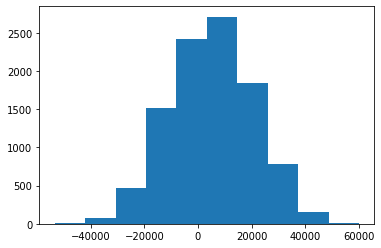

In [36]:
#you can copy my_pf.emp_dist to excel and create a histogram there
# ie my_pf.emp_dist
plt.hist(my_pf.emp_dist)

In [27]:
#backtested VaR shows reasonable results
-(perf_df['Return']).sort_values()[0:5]*100

2014-09-30    3.329737
2018-02-28    3.298596
2015-08-31    3.216431
2018-10-31    2.607064
2015-06-30    2.056538
Name: Return, dtype: float64

In [28]:
greeks = my_pf.calc_opt_greeks(env_now)

In [29]:
#potential(expected) PnL given a reasonable movement
print(greeks['delta']*env_now.prices['SPY US Equity']*0.01)
#we expect 1% movement in SPY over 1 month
print(0.5*greeks['gamma']*(env_now.prices['SPY US Equity']*0.01)**2)
print(greeks['vega']*0.01)
#we might expect a 1% move in vega
print(greeks['theta']/12)
# literally from 1 month of theta

940.0145443218476
-49.313692904505196
-427.2469357844576
2217.2955786984944


In [30]:
#scenario analysis 
from historical import Distribution, ShockMap


dist = Distribution(data, date, method = "Normal")
sm = ShockMap(data, date)
curr_port_value = my_pf.calc_value(env_now)
#print(curr_port_value)
pnl = []

#GDP down 1% monthly
sim_fact_shock = dist.generate_cond_shock_cf('GDP Change', condition = -0.01)
sim_shock = sm.map_factors_expected(sim_fact_shock)
sim_env = env_now.simulate(sim_shock)
#print(my_pf.calc_value(sim_env) - curr_port_value)
pnl.append(my_pf.calc_value(sim_env) - curr_port_value)

#Volatility up 50% 
sim_fact_shock = dist.generate_cond_shock_cf('IVMID Change', condition = 0.50)
sim_shock = sm.map_factors_expected(sim_fact_shock)
sim_env = env_now.simulate(sim_shock)
#print(my_pf.calc_value(sim_env) - curr_port_value)
pnl.append(my_pf.calc_value(sim_env) - curr_port_value)

#Volatility down 50%
sim_fact_shock = dist.generate_cond_shock_cf('IVMID Change', condition = -0.50)
sim_shock = sm.map_factors_expected(sim_fact_shock)
sim_env = env_now.simulate(sim_shock)
#print(my_pf.calc_value(sim_env) - curr_port_value)
pnl.append(my_pf.calc_value(sim_env) - curr_port_value)

#SPY down 5%
sim_fact_shock = dist.generate_cond_shock_cf('SPY Change', condition = -0.05)
sim_shock = sm.map_factors_expected(sim_fact_shock)
sim_env = env_now.simulate(sim_shock)
#print(my_pf.calc_value(sim_env) - curr_port_value)
pnl.append(my_pf.calc_value(sim_env) - curr_port_value)

#SPY up 5%
sim_fact_shock = dist.generate_cond_shock_cf('SPY Change', condition = 0.05)
sim_shock = sm.map_factors_expected(sim_fact_shock)
sim_env = env_now.simulate(sim_shock)
#print(my_pf.calc_value(sim_env) - curr_port_value)
pnl.append(my_pf.calc_value(sim_env) - curr_port_value)

#10Y IR up 1%
sim_fact_shock = dist.generate_cond_shock_cf('T10Y Change', condition = 0.01)
sim_shock = sm.map_factors_expected(sim_fact_shock)
sim_env = env_now.simulate(sim_shock)
#print(my_pf.calc_value(sim_env) - curr_port_value)
pnl.append(my_pf.calc_value(sim_env) - curr_port_value)

my_pf.calc_value(env_now)


596978.3890446571

In [31]:
Scenarios = ['GDP down 1%','Volatility Up 50%', 'Volatility Down 50%', 'SPY Down 5%', 'SPY Up 5%', '10Y IR Up 1%']
pnl

s_anal = pd.DataFrame(pnl, index = Scenarios, columns = ['PnL'])
s_anal['Percentage Change in Portfolio Value'] = (s_anal['PnL']/curr_port_value) * 100
s_anal


,PnL,Percentage Change in Portfolio Value
GDP down 1%,-4179.797815,-0.700159
Volatility Up 50%,-13429.482262,-2.249576
Volatility Down 50%,5502.028814,0.921646
SPY Down 5%,-11158.666201,-1.869191
SPY Up 5%,21933.728476,3.674124
10Y IR Up 1%,5032.244931,0.842953


In [32]:
#current portfolio ETF exposure values
my_pf.calc_value(env_now)
exposure = list(my_pf.pf_dollars.values())
names = []
for instru in list(my_pf.pf_dollars.keys()):
    names.append(instru.name)

exp_by_instru = pd.Series(exposure, index = names)
exp_by_instru


TIP US Equity      71528.334039
AGG US Equity      71528.334039
IEF US Equity      71528.334039
TLT US Equity      71528.334039
SHY US Equity      71528.334039
LQD US Equity      71528.334039
IYR US Equity      27098.430181
RWR US Equity      27098.430181
ICF US Equity      27098.430181
EWZ US Equity      25697.042099
ISMUF US Equity    25697.042099
ILF US Equity      25697.042099
SPY US Equity          0.000000
EFA US Equity          0.000000
XLF US Equity          0.000000
XLK US Equity          0.000000
XLV US Equity          0.000000
XLP US Equity          0.000000
XLE US Equity          0.000000
EWJ US Equity          0.000000
XLU US Equity          0.000000
XLI US Equity          0.000000
EZU US Equity          0.000000
XLB US Equity          0.000000
IXN US Equity          0.000000
IYZ US Equity          0.000000
IEV US Equity          0.000000
NaN                  481.951530
SPY Call 1         72738.615052
SPY Call 2        -95106.833935
SPY Call 3         31308.235324
dtype: f

In [33]:
# this is the equivalent dollar delta exposure of options. 
my_pf.calc_opt_greeks(env_now)['delta']*env_now.prices['SPY US Equity']


94001.45443218475

In [34]:
w_dict

{'TIP US Equity': 0.1217386645319019,
 'AGG US Equity': 0.1217386645319019,
 'IEF US Equity': 0.1217386645319019,
 'TLT US Equity': 0.1217386645319019,
 'SHY US Equity': 0.1217386645319019,
 'LQD US Equity': 0.1217386645319019,
 'IYR US Equity': 0.04612055831478875,
 'RWR US Equity': 0.04612055831478875,
 'ICF US Equity': 0.04612055831478875,
 'EWZ US Equity': 0.0437354459547408,
 'ISMUF US Equity': 0.0437354459547408,
 'ILF US Equity': 0.0437354459547408,
 'SPY US Equity': 0,
 'EFA US Equity': 0,
 'XLF US Equity': 0,
 'XLK US Equity': 0,
 'XLV US Equity': 0,
 'XLP US Equity': 0,
 'XLE US Equity': 0,
 'EWJ US Equity': 0,
 'XLU US Equity': 0,
 'XLI US Equity': 0,
 'EZU US Equity': 0,
 'XLB US Equity': 0,
 'IXN US Equity': 0,
 'IYZ US Equity': 0,
 'IEV US Equity': 0}